# Imports

In [0]:
!pip install pydub
!pip install keras_metrics

!pip install pydub
!apt-get install ffmpeg
!pip install librosa

In [0]:
import warnings
import wave
import random

import numpy as np
import pandas as pd

import itertools
import librosa

from pydub import AudioSegment
import IPython.display as ipd
from scipy.io import wavfile

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import keras
import tensorflow as tf
import keras_metrics
from tensorflow.python.client import device_lib
from keras import backend as K
from keras.utils.np_utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Dropout, MaxPooling2D, Input, Flatten, Conv2D
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.models import load_model
import librosa.display
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, RobustScaler

warnings.filterwarnings("ignore")

# Const vars

In [0]:
ROOT = 'drive/My Drive/MASR/'

TRAIN_DATA = ROOT + 'train_data/'
TRAIN_CSV_PATH = 'csv_data/train_data.csv'

TEST_DATA = ROOT + 'test_data/'
TEST_CSV_PATH = 'csv_data/test_data.csv' 

VALID_DATA = ROOT + 'valid_data/'
VALID_CSV_PATH = 'csv_data/valid_data.csv'

# heuristic generated from trainig data
RANDOM_SEED = 42
TRUNCATED_MAX = 56831
STRIDE = 3
SAMPLING_RATE = 22050
NUM_CLASSES = 5
CHANNELS = 1
TEST_SIZE = .3
RANDOM_SEED = 42

# Utils

In [0]:
train_data_file_paths = sorted([TRAIN_DATA + f for f in os.listdir(path=TRAIN_DATA)])
test_data_file_paths = sorted([TEST_DATA + f for f in os.listdir(path=TEST_DATA)])
valid_data_file_paths = sorted([VALID_DATA + f for f in os.listdir(path=VALID_DATA)])

In [0]:
DEFAULT_SOUND = PROCESSED_DATA+'1/zviad-noza-1e.wav'
# Get folder paths to wav files
# We have 5 folders - one for each nubmber.
processed_data_file_paths = sorted([PROCESSED_DATA + f for f in os.listdir(path=PROCESSED_DATA)])


def plot_spectrogram(file=DEFAULT_SOUND, figsize=(15, 8), fig_id=1):
    """ Visualizes wav file x axis is time and y is amplitude

        Params:
        file    - (str) wav file name to vizualize
        figsize - (tuple of 2 ints) plot's figure size 
        fig_id  - (Number) figure id if same for two calls plots on
                        same figure if different on different figures
    """
    with wave.open(file, 'r') as wav_file:
        # Extract Raw Audio from Wav File
        signal = np.fromstring(wav_file.readframes(-1), 'Int16')

        # Split the data into channels
        num_channels = wav_file.getnchannels()
        channels = [signal[channel::num_channels]
                    for channel in range(num_channels)]

        # Get time from indices
        sound_length = len(signal)/len(channels)/wav_file.getframerate()
        time_ = np.linspace(0, sound_length, num=len(signal)/len(channels))
        # print('sound length - ', sound_length)
        # Plot
        plt.figure(fig_id, figsize=figsize)
        plt.title(file)
        plt.xlabel('Time')
        plt.ylabel('Amplitude')

        for channel in channels:
            plt.plot(time_, channel)
        plt.show()

def plot_random_spectrograms(dirs=processed_data_file_paths, num_fig_per_sound=1, plot_as_scrollable=False, seed=42):
    """ Plots specified number of sound waves
        (spectograms) 
        
        Params:
        dirs               - (str)     directoryes where are sound files 
        num_fig_per_sound  - (Number)  number of spectogram plots per unique number sound
        plot_as_scrollable - (Boolean) for lots of plot it's nice to scroll between plots
                                       and for small number of plots its better to plot them 
                                       without scroll to easyly compare them
        seed               - (Integer) random seed library 'random'
    """
    random.seed(seed)
    fig_id = 1
    for dir_name in dirs:
        sound_files = os.listdir(dir_name)
        indices = random.sample(range(1, len(sound_files)), num_fig_per_sound)
        print('='*40, dir_name.split('/')[1], '='*40)
        for i in indices:
            fname = dir_name+'/'+sound_files[i]
            plot_spectrogram(file=fname, figsize=(10, 3), fig_id=fig_id)
            fig_id += 1
    if not plot_as_scrollable:
        js = "<script>$('.output_scroll').removeClass('output_scroll')</script>"
        ipd.display(ipd.HTML(js))

======================================== My Drive ========================================


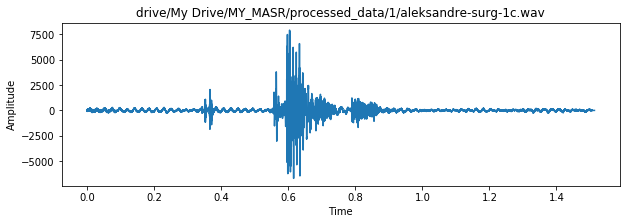

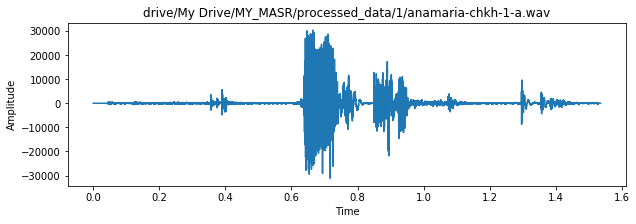

======================================== My Drive ========================================


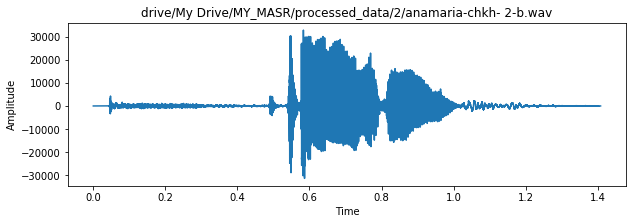

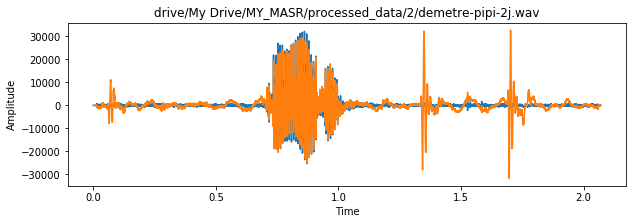

======================================== My Drive ========================================


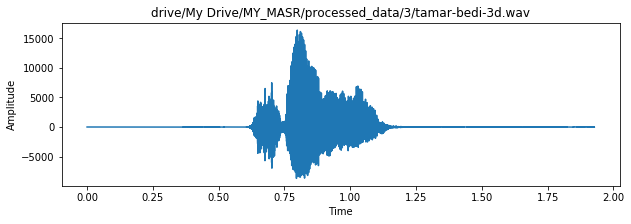

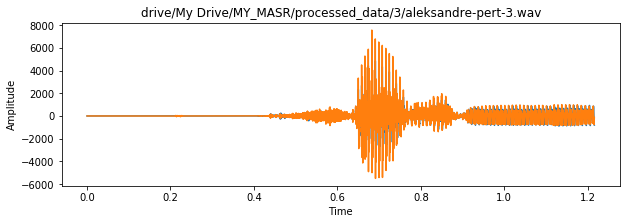

======================================== My Drive ========================================


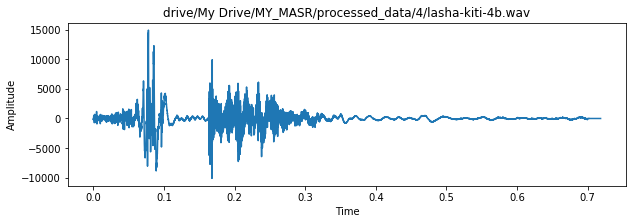

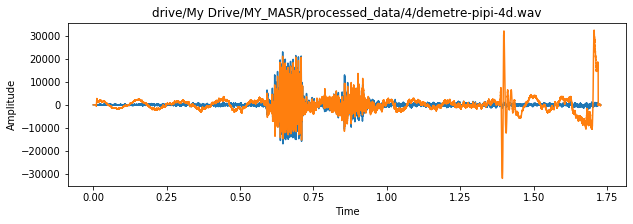

======================================== My Drive ========================================


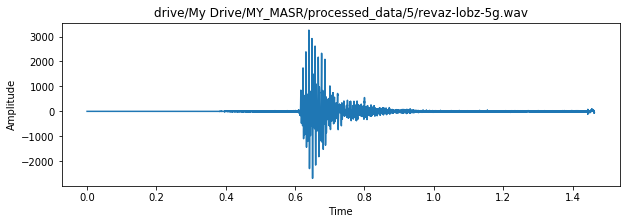

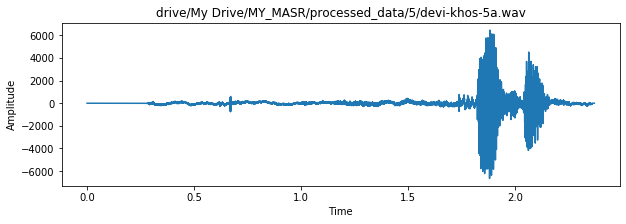

In [0]:
plot_random_spectrograms(num_fig_per_sound=2)

In [0]:
"""IF WANT ADDING NAMES OF RECORDER PEOPLE UNCOMMENT INNER LOOPS"""

def load_data(data_path=processed_data_file_paths, mask=0):
    """ Loads .wav sounds from passed paths into pandas.DataFrame,
        fills shorter sounds with specified mask

        Params:
        data_path   - (list of strings) list containing all paths to files to load
        mask        - (Number) mask is value of filling shorter sounds to match length of longest

        Returns: 
            <class 'pandas.core.frame.DataFrame'>
            RangeIndex: 659 entries, 0 to 658
            Columns: 81795 entries, target to 81791
            dtypes: float32(81792), int32(3)
            memory usage: 205.6 MB    
        pands.DataFrame column names and descriprions are: 
            'target'        - (int32) recorded number
            'sound_length'  - (int32) column index where masking starts
            'sampling_rate' - (int32) sampling rate of recording (https://techterms.com/definition/sample_rate) 
             next col names are 0 . . . max sound length in files (dtype float32)
    """
    counter = 0
    data = []
    filenames = []
    for dir_name in data_path:
        target = int(dir_name.split('/')[-1]) 
        for fname in os.listdir(dir_name):
            # load vound file
            sample, sampling_rate = librosa.load(dir_name+'/'+fname)
            # prepend sampling rate
            sample = np.append(sampling_rate, sample)
            # prepend length of sound file
            sample_length = sample.shape[0]
            sample = np.append(sample_length, sample)
            # prepend target of sample
            sample = np.append(target, sample)
            file_name = fname# get file name
            filenames.append(file_name)
            data.append(sample)
            counter += 1
            if counter % 100 == 0:
                print(counter, '- voices loaded')
    
    data = pd.DataFrame(data).fillna(mask)
    filenameDF = pd.DataFrame(filenames).fillna(mask)
    data = data.astype('float32')
    # set colum names to more informative names
    sound_description_col_names = {0: "target", 1: "sound_length", 2: "sampling_rate"}
    sound_sample_col_names = { col_indx: str(int(col_indx) - len(sound_description_col_names)) for col_indx in data.columns[len(sound_description_col_names):]}
    column_names = {**sound_description_col_names, **sound_sample_col_names}
    data.rename(columns=column_names, inplace=True)
    
    # change types of target length and rate
    col_types = {'target': 'int32', 'sound_length': 'int32', 'sampling_rate': 'int32'}
    data = data.astype(col_types)
    filenameDF.rename(columns={0: "filenames"}, inplace=True)
    
    return data, filenameDF
            
def play_row_as_sound(dataframe, row_indx):
    """ Returns playable audio file

        Params:
        dataframe (pandas.DataFrame) dataframe where audio sample is stored
        row_indx  (int) index of audio sample in dataframe    
    """
    return ipd.Audio(dataframe.iloc[row_indx, 3:].values, rate=22050)

def play_np_as_sound(arr, sr=22050):
    return ipd.Audio(arr, rate=sr)

In [0]:
def load_data2(data_path=train_data_file_paths, mask=0):
    counter, data = 0, []
    for dir_name in data_path:
        target = int(dir_name.split('/')[-1]) 
        for fname in os.listdir(dir_name):
            sample, sampling_rate = librosa.load(dir_name+'/'+fname)
            sample = np.append(sampling_rate, sample)
            sample_length = sample.shape[0]
            sample = np.append(sample_length, sample)
            sample = np.append(target, sample)
            data.append(sample)
            counter += 1
            if counter % 100 == 0:
                print(counter, '- voices loaded')
    data = pd.DataFrame(data).fillna(mask)
    data = data.astype('float32')
    sound_description_col_names = {0: "target", 1: "sound_length", 2: "sampling_rate"}
    sound_sample_col_names = { col_indx: str(int(col_indx) - len(sound_description_col_names)) for col_indx in data.columns[len(sound_description_col_names):]}
    column_names = {**sound_description_col_names, **sound_sample_col_names}
    data.rename(columns=column_names, inplace=True)
    col_types = {'target': 'int32', 'sound_length': 'int32', 'sampling_rate': 'int32'}
    data = data.astype(col_types)
    return data
            
def add_noise(x, noise_factor=.005):
    noise = np.random.randn(len(x))
    noisy = x + noise_factor * noise
    noisy = noisy.astype(type(x[0]))
    return noisy

def change_pitch(x, pitch_factor=4, sr=SAMPLING_RATE):
    return librosa.effects.pitch_shift(x, sr, pitch_factor)

def speed_up(x, length, speed_factor=1.3):
    without_pad = x[:length]
    speeded = librosa.effects.time_stretch(without_pad, speed_factor)
    speeded_len = speeded.shape[0]
    silent_end = np.zeros((x.shape[0] - speeded_len,))
    speeded = np.concatenate((speeded, silent_end))
    return speeded, speeded_len

def move_pading_in_front(x, l):
    return np.concatenate([x[l:], x[:l]])

def move_pading_in_middle(x, l):
    original_silence = x.shape[0] - l
    silent_half = int(original_silence / 2)
    silent_left = np.zeros((silent_half,))
    middle_sound= x[:l]
    silent_right= np.zeros((original_silence - silent_half,))
    return np.concatenate([silent_left, middle_sound, silent_right])

def mfcc_X_y_from_pd(df, stride=STRIDE):
    y = keras.utils.np_utils.to_categorical(df.y.values - 1, num_classes=NUM_CLASSES)
    X = np.array([librosa.feature.mfcc(x[::stride], sr=SAMPLING_RATE) for x in df.X.values]) # get every strideth sample
    X = X.reshape((X.shape[0], X.shape[1], X.shape[2], CHANNELS))
    return X, y

def truncate_length(df, truncated_max=TRUNCATED_MAX):
    df.drop([str(c) for c in range(truncated_max, df.shape[-1] - 3)], axis=1, inplace=True)
    df.loc[df.sound_length > truncated_max, 'sound_length'] = truncated_max
    return df

def convert_sound_to_np(df):
    return pd.DataFrame({
        'y':df.target.copy(),
        'X':[np.array(x) for x in df.drop(['target', 'sampling_rate', 'sound_length'], axis=1).values],
        'L':df.sound_length.copy()
    })

def load_preprocess(path):
    df = pd.read_csv(path)
    df = df.astype('float32')
    df = df.astype({'target': 'int32', 'sound_length': 'int32', 'sampling_rate': 'int32'})
    df = truncate_length(df)
    df = convert_sound_to_np(df)
    return df

In [0]:
# UNCOMMENT THIS TO READ .wav data AND LOAD IN FILE IN CSV 

train_data = load_data(train_data_file_paths)
train_data.to_csv(path_or_buf=ROOT+TRAIN_CSV_PATH, index=False)

valid_data = load_data(valid_data_file_paths)
valid_data.to_csv(path_or_buf=ROOT+VALID_CSV_PATH, index=False)

test_data = load_data(test_data_file_paths)
test_data.to_csv(path_or_buf=ROOT+TEST_CSV_PATH, index=False)

train_data.info(), valid_data.info(), test_data.info()

# Load data

In [0]:
train_sounds = load_preprocess(ROOT+TRAIN_CSV_PATH)
valid_sounds = load_preprocess(ROOT+VALID_CSV_PATH)
test_sounds  = load_preprocess(ROOT+TEST_CSV_PATH)

train_sounds.info(), valid_sounds.info(), test_sounds.info()

# Augment

In [0]:
# inject noise
noise_injected = pd.DataFrame({
    'y':train_sounds.y.copy(),
    'X':train_sounds.X.copy().map(add_noise),
    'L':train_sounds.L.copy()
})

# change pitch
pitch_changed = pd.DataFrame({
    'y':train_sounds.y.copy(),
    'X':train_sounds.X.copy().map(change_pitch),
    'L':train_sounds.L.copy()
})

# change speed (fasten)
speeded_and_len = [speed_up(x, l) for x,l in zip(train_sounds.X.copy(), train_sounds.L.copy())]
speeded_up = pd.DataFrame({
    'y':train_sounds.y.copy(),
    'X':[x for x,l in speeded_and_len],
    'L':[l for x,l in speeded_and_len]
})

# concatenate augmentations
augmented_train_sounds = pd.concat([train_sounds, noise_injected, pitch_changed, speeded_up], axis=0, ignore_index=True) 

# shift sound to end
padded_in_front = pd.DataFrame({
    'y':augmented_train_sounds.y.copy(),
    'X':[move_pading_in_front(x, l) for x, l in zip(augmented_train_sounds.X.copy(), augmented_train_sounds.L.copy())],
})

# shift sound in middle
padded_on_both_ends = pd.DataFrame({
    'y':augmented_train_sounds.y.copy(),
    'X':[move_pading_in_middle(x, l) for x, l in zip(augmented_train_sounds.X.copy(), augmented_train_sounds.L.copy())],
})

concated = pd.concat([augmented_train_sounds.drop(['L'], axis=1), padded_in_front, padded_on_both_ends], axis=0, ignore_index=True) 

# shuffle data
train_sounds = concated.reindex(np.random.permutation(concated.index))

In [0]:
# READ .wav data AND LOAD IN FILE IN CSV 
# Returns data of wav files translated into csv and another dataframe consisting
# of the respected file names. File names are most likely not needed here
data,filenameDF = load_data(processed_data_file_paths)

# Ideally this his code doesn't need to be run more than once.
data.to_csv(path_or_buf=ROOT+CSV_DATA, index=False)
data.info()

100 - voices loaded
200 - voices loaded
300 - voices loaded
400 - voices loaded
500 - voices loaded
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 502 entries, 0 to 501
Columns: 81795 entries, target to 81791
dtypes: float32(81792), int32(3)
memory usage: 156.6 MB


In [0]:
# Read data from csv file.
sound_data = pd.read_csv(ROOT+CSV_DATA)
# change datatype to 32 bit lengths to use memory efficiently
sound_data = sound_data.astype('float32')
sound_data = sound_data.astype({'target': 'int32', 'sound_length': 'int32', 'sampling_rate': 'int32'})
sound_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 502 entries, 0 to 501
Columns: 81795 entries, target to 81791
dtypes: float32(81792), int32(3)
memory usage: 156.6 MB


### So EDA begins


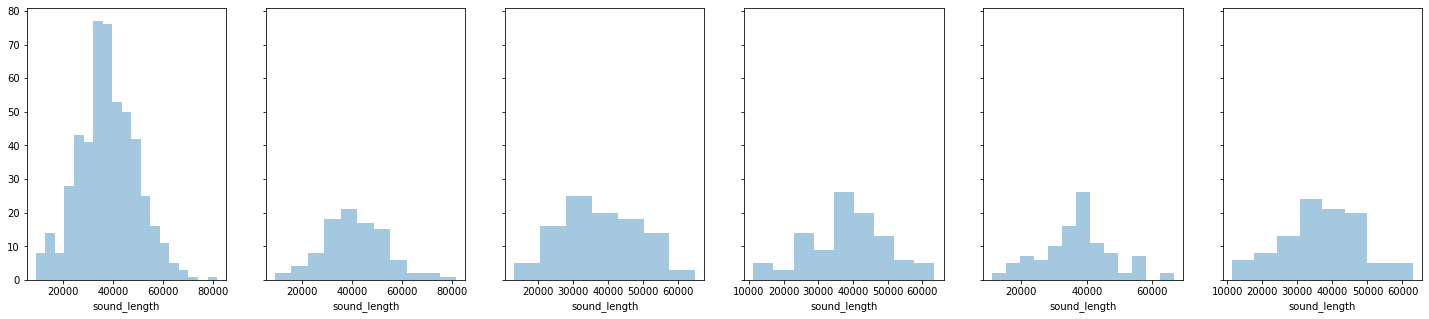

In [0]:
fig, (ax0, ax1, ax2, ax3, ax4, ax5) = plt.subplots(ncols=6, sharey=True)
fig.set_figheight(5)
fig.set_figwidth(25)
sns.distplot(sound_data['sound_length'], kde=False, ax=ax0)
sns.distplot(sound_data.loc[sound_data['target'] == 1]['sound_length'], kde=False, ax=ax1)
sns.distplot(sound_data.loc[sound_data['target'] == 2]['sound_length'], kde=False, ax=ax2)
sns.distplot(sound_data.loc[sound_data['target'] == 3]['sound_length'], kde=False, ax=ax3)
sns.distplot(sound_data.loc[sound_data['target'] == 4]['sound_length'], kde=False, ax=ax4)
sns.distplot(sound_data.loc[sound_data['target'] == 5]['sound_length'], kde=False, ax=ax5)


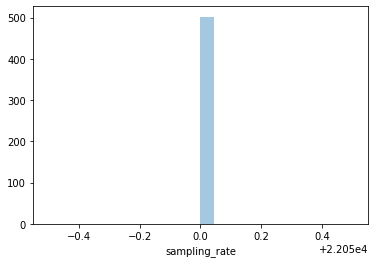

In [0]:
sns.distplot(sound_data['sampling_rate'], kde=False)

In [0]:
# none of values are nan
sound_data.isna().any().any()

False

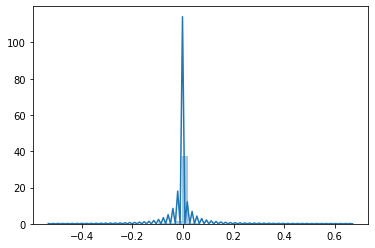

In [0]:
# Visualize distribution of amplitudes for one sound recording
sns.distplot(sound_data.iloc[180, 3:].values, kde=True)

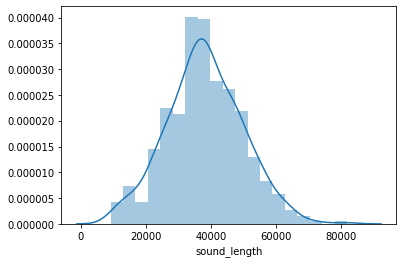

In [0]:
sns.distplot(sound_data['sound_length'], kde=True)

In [0]:
sound_data_checkpoint = pd.DataFrame.copy(sound_data, deep=True)
print(sound_data_checkpoint.shape)

(502, 81795)


In [0]:
sound_data = pd.DataFrame.copy(sound_data_checkpoint, deep=True)
print(sound_data.shape)

(502, 81795)


In [0]:
# so its more or less like to normal ditribution 
avg = int(sound_data.sound_length.mean())
std = int(sound_data.sound_length.std())
m_x = int(sound_data.shape[-1])

# let's truncate lenght of sounds by mean + 2 * std
truncated_max = avg + 2 * std

# print num truncated
longest_sounds = sound_data.loc[sound_data.sound_length > truncated_max]

# truncate
sound_data.drop([str(c) for c in range(truncated_max, sound_data.shape[-1] - 3)], axis=1, inplace=True)

# change length of longer sounds then trunncated_max
sound_data.loc[sound_data.sound_length > truncated_max, 'sound_length'] = truncated_max

print(sound_data.shape)

(502, 61465)


In [0]:
# Convert in more comfortable format

sounds = pd.DataFrame({
    'y':sound_data.target.copy(),
    'X':[np.array(x) for x in sound_data.drop(['target', 'sampling_rate', 'sound_length'], axis=1).values],
    'L':sound_data.sound_length.copy()
})
sounds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 502 entries, 0 to 501
Data columns (total 3 columns):
y    502 non-null int32
X    502 non-null object
L    502 non-null int32
dtypes: int32(2), object(1)
memory usage: 8.0+ KB


In [0]:
# inject noise

noise_injected = pd.DataFrame({
    'y':sounds.y.copy(),
    'X':sounds.X.copy().map(add_noise),
    'L':sounds.L.copy()
})

In [0]:
# change pitch

pitch_changed = pd.DataFrame({
    'y':sounds.y.copy(),
    'X':sounds.X.copy().map(change_pitch),
    'L':sounds.L.copy()
})

In [0]:
# change speed (fasten)

speeded_and_len = [speed_up(x, l) for x,l in zip(sounds.X.copy(), sounds.L.copy())]

speeded_up = pd.DataFrame({
    'y':sounds.y.copy(),
    'X':[x for x,l in speeded_and_len],
    'L':[l for x,l in speeded_and_len]
})

In [0]:
# concatenate augmentations
augmented_sounds = pd.concat([sounds, noise_injected, pitch_changed, speeded_up], axis=0, ignore_index=True) 
augmented_sounds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2008 entries, 0 to 2007
Data columns (total 3 columns):
y    2008 non-null int32
X    2008 non-null object
L    2008 non-null int64
dtypes: int32(1), int64(1), object(1)
memory usage: 39.3+ KB


In [0]:
# shift sound to end

padded_in_front = pd.DataFrame({
    'y':augmented_sounds.y.copy(),
    'X':[move_pading_in_front(x, l) for x, l in zip(augmented_sounds.X.copy(), augmented_sounds.L.copy())],
})

In [0]:
# shift sound in middle

padded_on_both_ends = pd.DataFrame({
    'y':augmented_sounds.y.copy(),
    'X':[move_pading_in_middle(x, l) for x, l in zip(augmented_sounds.X.copy(), augmented_sounds.L.copy())],
})

In [0]:
concated = pd.concat([augmented_sounds.drop(['L'], axis=1), padded_in_front, padded_on_both_ends], axis=0, ignore_index=True)
concated.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6024 entries, 0 to 6023
Data columns (total 2 columns):
y    6024 non-null int32
X    6024 non-null object
dtypes: int32(1), object(1)
memory usage: 70.7+ KB


# Train/test split 

In [0]:
# split data

train_X, train_y = mfcc_X_y_from_pd(train_sounds)
valid_X, valid_y = mfcc_X_y_from_pd(valid_sounds)
test_X , test_y  = mfcc_X_y_from_pd(test_sounds)

# Train Keras

Model: "sequential_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_139 (Conv2D)          (None, 19, 37, 64)        320       
_________________________________________________________________
batch_normalization_303 (Bat (None, 19, 37, 64)        256       
_________________________________________________________________
dropout_303 (Dropout)        (None, 19, 37, 64)        0         
_________________________________________________________________
conv2d_140 (Conv2D)          (None, 18, 36, 128)       32896     
_________________________________________________________________
batch_normalization_304 (Bat (None, 18, 36, 128)       512       
_________________________________________________________________
average_pooling2d_24 (Averag (None, 9, 18, 128)        0         
_________________________________________________________________
dropout_304 (Dropout)        (None, 9, 18, 128)      

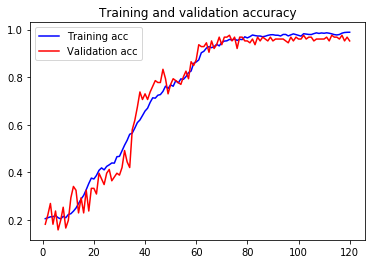

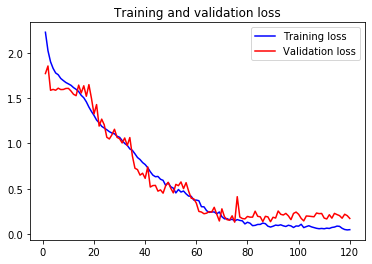

<Figure size 432x288 with 0 Axes>

145/145 [==============================] - 0s 282us/step
Test set
  Loss: 0.729
  Accuracy: 0.862


In [0]:
# train
epochs = 120
dropout_p = .4
batch_size = 128
padding = 'valid'
conv_kernel_size = (2, 2)
pool_kernel_size = (2, 2)

model = keras.models.Sequential([
    keras.layers.Conv2D(64, 
                    input_shape=train_X.shape[1:], 
                    kernel_size=conv_kernel_size, 
                    activation='relu', 
                    padding=padding
                ),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(dropout_p),

    keras.layers.Conv2D(128, 
                    kernel_size=conv_kernel_size, 
                    activation='relu', 
                    padding=padding
                ),
    keras.layers.BatchNormalization(),
    keras.layers.AveragePooling2D(pool_size=pool_kernel_size),
    keras.layers.Dropout(dropout_p),

    keras.layers.Conv2D(256, 
                    kernel_size=conv_kernel_size, 
                    activation='relu',
                    padding=padding
                ),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(dropout_p),

    keras.layers.Conv2D(512,
                    kernel_size=conv_kernel_size, 
                    activation='relu', 
                    padding=padding
                ),
    keras.layers.BatchNormalization(),
    keras.layers.AveragePooling2D(pool_size=pool_kernel_size),
    keras.layers.Dropout(dropout_p),

    keras.layers.Conv2D(512,
                    kernel_size=conv_kernel_size, 
                    activation='relu', 
                    padding=padding
                ),
    keras.layers.BatchNormalization(),
    keras.layers.AveragePooling2D(pool_size=pool_kernel_size),
    keras.layers.Dropout(dropout_p),

    keras.layers.Flatten(),
    
    keras.layers.Dense(256, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(dropout_p),

    keras.layers.Dense(128, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(dropout_p),

    keras.layers.Dense(64, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(dropout_p),

    keras.layers.Dense(64, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(dropout_p),

    keras.layers.Dense(32, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(dropout_p),
    
    keras.layers.Dense(5, activation='softmax')
])

model.compile(
    optimizer='adam', 
    loss='categorical_crossentropy', 
    metrics=['acc']
)

print(model.summary())

history = model.fit(
    train_X, 
    train_y, 
    epochs=epochs, 
    batch_size=batch_size, 
    validation_data=[valid_X, valid_y], 
    verbose=2
)  

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()

plt.show()

accr = model.evaluate(test_X, test_y)
form = 'Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'
print(form.format(accr[0],accr[1]))


# Test Keras 

In [0]:
model_path = ROOT + 'e={}_b={}_d={}_acc={:0.3f}.h5'.format(len(epochs),batch_size,dropout_p,accr[1])
model.save(model_path)

In [0]:
m = keras.models.load_model('/content/drive/My Drive/MASR/e=150_b=128_d=0.4_acc=0.931.h5')

In [0]:
x = np.concatenate([test_X], axis=0)
y = np.concatenate([test_y], axis=0)
a = m.evaluate(test_X,test_y)
print(form.format(a[0],a[1]))

145/145 [==============================] - 7s 47ms/step
Test set
  Loss: 0.393
  Accuracy: 0.931
